# BP for MLP

## 1. Forward

设共有$L$层

$ z^l \in\mathbb R^{n}$ 为第 $ l $ 层经过激活函数前的输出<br>
$ a^l \in\mathbb R^{m} $ 为第 $ l $ 层经过激活函数后的输出<br>
$ \sigma $ 为激活函数<br>
$ \mathbf W^l \in\mathbb R^{n\times m} $ 为第 $ l $ 层的权重矩阵<br>
$ b^l \in\mathbb R^{n} $ 为第 $ l $ 层的偏置项<br>

$$ z^l = \mathbf W^la^{l-1}+b^l $$

$$ a^l = \sigma(z^l) $$

## 2.Backward

最终误差:$ C $

第$l$层的误差: $\delta^l$, 满足$$\delta^l=\frac{\partial C}{\partial z^l}$$

例如，对于MSE，$$C=\frac 1 2 \left\|a^L-y\right\|^2_2$$

输出层的误差$$\delta^L=\frac{\partial C}{\partial z^L}=\frac{\partial C}{\partial a^L}\frac{\partial a^L}{\partial z^L}=(a^L-y)\odot\sigma'(z^L)$$
其中，$\odot$为Hadamard积

接着求最终误差$C$对于输出层权重矩阵和偏置的偏导

$$\frac{\partial C}{\partial \mathbf W^L}=\frac{\partial C}{\partial z^L}\frac{\partial z^L}{\partial \mathbf W^L}=\delta^L(a^{L-1})^T$$

ps: 矩阵求导时，即乘上系数的转置，左乘还是右乘和求导前一致

$$\frac{\partial C}{\partial b^L}=\frac{\partial C}{\partial z^L}\frac{\partial z^L}{\partial b^L}=\delta^L\odot\mathbf 1=\delta^L$$

接着求第$l$层的误差$\delta^l$
$$ \delta^l=\frac{\partial C}{\partial z^l}
           =\frac{\partial C}{\partial z^{l+1}}\frac{\partial z^{l+1}}{\partial z^{l}}
           =\delta^{l+1}\frac{\partial z^{l+1}}{\partial z^{l}}
$$

又：
$$
z^{l+1}=\mathbf W^{l+1}a^l+b^{l+1}
       =\mathbf W^{l+1}\sigma(z^l)+b^{l+1}
$$

求得：
$$
\delta^{l}
=(\mathbf W^{l+1})^T\delta^{l+1}\odot\sigma'(z^l)
$$

于是可以求出每一层的参数：
$$
\frac{\partial C}{\partial\mathbf W^l} = \frac{\partial C}{\partial z^l}\frac{\partial z^l}{\partial \mathbf W^l}
=\delta^l(a^{l-1})^T
$$

$$
\frac{\partial C}{\partial b^l} = \frac{\partial C}{\partial z^l}\frac{\partial z^l}{\partial \mathbf b^l}
=\delta^l\odot\mathbf 1
=\delta^l
$$

然后就可以通过梯度下降对每一层参数进行更新：
$$
\mathbf W^l\leftarrow\mathbf W^l-\eta\frac{\partial C}{\partial\mathbf W^l}
$$

$$
b^l\leftarrow b^l-\eta\frac{\partial C}{\partial b^l}
$$

SGD的话，每次只用$bs$个样本，所以每次更新的参数为：
$$
\mathbf W^l\leftarrow\mathbf W^l-\frac{\eta}{bs}\sum_{i=1}^{bs}\frac{\partial C_i}{\partial\mathbf W^l}
$$

$$
b^l\leftarrow b^l-\frac{\eta}{bs}\sum_{i=1}^{bs}\frac{\partial C_i}{\partial b^l}
$$

In [4]:
from typing import Any
import numpy as np
from numpy.random import randn

class MLP:
    def __init__(self, params) -> None:
        self.L = params['layers']
        self.arch = params['arch']
        self.weights = [randn(y, x) for x, y in self.arch]
        self.biases = [randn(x, 1) for _, x in self.arch]
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.sigmoid_prime = lambda x: self.sigmoid(x) * (1 - self.sigmoid(x))
        
        self._z = []
        self._a = []

        self.deltas = [None for _ in range(self.L)]
        self.grad_ws = [np.zeros_like(W) for W in self.weights]
        self.grad_bs = [np.zeros_like(b) for b in self.biases]


    def forward(self, x) -> np.ndarray:
        assert len(x.shape) == 2, "Input must be a 2D array"
        self._z = []
        self._a = []
        x = x.T
        for weight, bias in zip(self.weights, self.biases):
            x = weight @ x
            x = x + bias
            self._z.append(x)
            x = self.sigmoid(x)
            self._a.append(x)
        return x.T
    
    def backward(self, lr, bs) -> None:
        for i in range(self.L-1 - 1, -1, -1):
            self.weights[i] = self.weights[i] - lr * self.grad_ws[i] / bs
            self.biases[i] = self.biases[i] - lr * self.grad_bs[i] / bs
        return

    def calc_grad(self, y_hat, y) -> None:
        assert len(y_hat.shape) == 2, "Input must be a 2D array"
        assert len(y.shape) == 2, "Input must be a 2D array"
        y_hat = y_hat.T
        y = y.T
        
        self.deltas[self.L-1] = (y_hat - y) * self.sigmoid_prime(self._z[self.L-1])
        self.grad_ws[self.L-1] += self.deltas[self.L-1] @ self._a[self.L-1 - 1].T
        self.grad_bs[self.L-1] += self.deltas[self.L-1]
        for i in range(self.L-1 - 1, 2 - 1, -1):
            self.deltas[i] = self.weights[i+1].T @ self.deltas[i+1] * self.sigmoid_prime(self._z[i])
            self.grad_ws[i] += self.deltas[i] @ self._a[i - 1].T
            self.grad_bs[i] += self.deltas[i]
        return

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return self.forward(*args, **kwds)

Epoch 1/100 | Loss: 0.1909
Epoch 2/100 | Loss: 2.5192
Epoch 3/100 | Loss: 0.0000
Epoch 4/100 | Loss: 0.1084
Epoch 5/100 | Loss: 0.6966
Epoch 6/100 | Loss: 0.0027
Epoch 7/100 | Loss: 0.1180
Epoch 8/100 | Loss: 0.0083
Epoch 9/100 | Loss: 0.3331
Epoch 10/100 | Loss: 0.0522
Epoch 11/100 | Loss: 0.2954
Epoch 12/100 | Loss: 0.0501
Epoch 13/100 | Loss: 0.8623
Epoch 14/100 | Loss: 1.6214
Epoch 15/100 | Loss: 0.0000
Epoch 16/100 | Loss: 0.1412
Epoch 17/100 | Loss: 0.0163
Epoch 18/100 | Loss: 0.0108
Epoch 19/100 | Loss: 0.2307
Epoch 20/100 | Loss: 0.4595
Epoch 21/100 | Loss: 0.0974
Epoch 22/100 | Loss: 0.6821
Epoch 23/100 | Loss: 0.3078
Epoch 24/100 | Loss: 0.0120
Epoch 25/100 | Loss: 0.0892
Epoch 26/100 | Loss: 0.9029
Epoch 27/100 | Loss: 0.6590
Epoch 28/100 | Loss: 1.5437
Epoch 29/100 | Loss: 0.0136
Epoch 30/100 | Loss: 2.1972
Epoch 31/100 | Loss: 1.9617
Epoch 32/100 | Loss: 0.0261
Epoch 33/100 | Loss: 0.1400
Epoch 34/100 | Loss: 0.5060
Epoch 35/100 | Loss: 1.3847
Epoch 36/100 | Loss: 0.8121
E

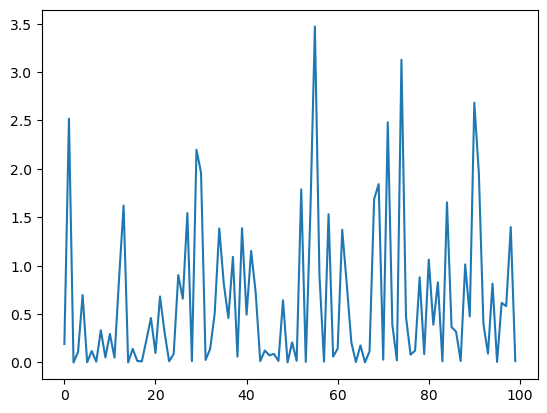

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

params = {
    'layers': 3,
    'arch': [(2, 3), (3, 4), (4, 1)]
}

BATCH_SIZE = 1
LEARNING_RATE = 0.01
EPOCHS = 100

model = MLP(params=params)

losses = []
for epoch in range(EPOCHS):
    x = np.random.randn(BATCH_SIZE, 2)
    y = np.random.randn(BATCH_SIZE, 1)
    y_hat = model(x)
    loss = np.mean((y_hat - y)**2) / 2
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss:.4f}")
    # print(y_hat.shape)
    model.calc_grad(y_hat, y)
    model.backward(lr=LEARNING_RATE, bs=BATCH_SIZE)
    losses.append(loss)

# loss plot, update
plt.plot(losses)
    

In [103]:
model = MLP(params=params)
model(np.random.randn(1, 2))

array([[0.14353839]])

In [100]:
z = [None]

In [87]:
z.append(np.zeros(1))

In [88]:
z

[None, array([0.])]

In [114]:
np.random.randn(1, 2) @ np.random.randn(2, 3) * np.random.randn(3, 2)

ValueError: operands could not be broadcast together with shapes (1,3) (3,2) 